3/5/25 High Flow and Lag Time

Focus on ratios of big events (usually flow is less than precip): Isolate Storm Runoff & Perform Baseflow Separation

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
from simpledbf import Dbf5

In [ ]:
# read in flow:precip ratio data- note flow is in cfs but normalized flow is in mm/day
daymet_usgs = pd.read_csv("daily_flow_precip_2013_2024.csv", dtype={'site_id': str}) #site_id is not 
daymet_usgs

,year,yday,prcp (mm/day),lat,lon,site_id,datetime,flow,normalized_flow,flow_precip_ratio
0,2013.0,1.0,0.00,41.658983,-73.528458,01200000,2013-01-01,408.0,1.874264,inf
1,2013.0,2.0,0.00,41.658983,-73.528458,01200000,2013-01-02,376.0,1.727263,inf
2,2013.0,3.0,0.00,41.658983,-73.528458,01200000,2013-01-03,345.0,1.584855,inf
3,2013.0,4.0,0.00,41.658983,-73.528458,01200000,2013-01-04,338.0,1.552699,inf
4,2013.0,5.0,0.00,41.658983,-73.528458,01200000,2013-01-05,331.0,1.520543,inf
...,...,...,...,...,...,...,...,...,...,...
582170,2023.0,361.0,6.19,43.463959,-73.284276,04280450,2023-12-27,543.0,3.049586,0.492663
582171,2023.0,362.0,2.43,43.463959,-73.284276,04280450,2023-12-28,550.0,3.088899,1.271152
582172,2023.0,363.0,5.67,43.463959,-73.284276,04280450,2023-12-29,508.0,2.853020,0.503178
582173,2023.0,364.0,1.37,43.463959,-73.284276,04280450,2023-12-30,640.0,3.594355,2.623617


In [3]:
#ratio = daymet_usgs

In [4]:
ratio = daymet_usgs.copy()
ratio

,year,yday,prcp (mm/day),lat,lon,site_id,datetime,flow,normalized_flow,flow_precip_ratio
0,2013.0,1.0,0.00,41.658983,-73.528458,01200000,2013-01-01,408.0,1.874264,inf
1,2013.0,2.0,0.00,41.658983,-73.528458,01200000,2013-01-02,376.0,1.727263,inf
2,2013.0,3.0,0.00,41.658983,-73.528458,01200000,2013-01-03,345.0,1.584855,inf
3,2013.0,4.0,0.00,41.658983,-73.528458,01200000,2013-01-04,338.0,1.552699,inf
4,2013.0,5.0,0.00,41.658983,-73.528458,01200000,2013-01-05,331.0,1.520543,inf
...,...,...,...,...,...,...,...,...,...,...
582170,2023.0,361.0,6.19,43.463959,-73.284276,04280450,2023-12-27,543.0,3.049586,0.492663
582171,2023.0,362.0,2.43,43.463959,-73.284276,04280450,2023-12-28,550.0,3.088899,1.271152
582172,2023.0,363.0,5.67,43.463959,-73.284276,04280450,2023-12-29,508.0,2.853020,0.503178
582173,2023.0,364.0,1.37,43.463959,-73.284276,04280450,2023-12-30,640.0,3.594355,2.623617


In [5]:
# Replace missing data (-99999) with 0 - this also gets rid of a line in the graph below
ratio["flow"] = ratio["flow"].apply(lambda x: max(x, 0)) 
ratio["normalized_flow"] = ratio["normalized_flow"].apply(lambda x: max(x, 0)) 

(0.0, 120.0)

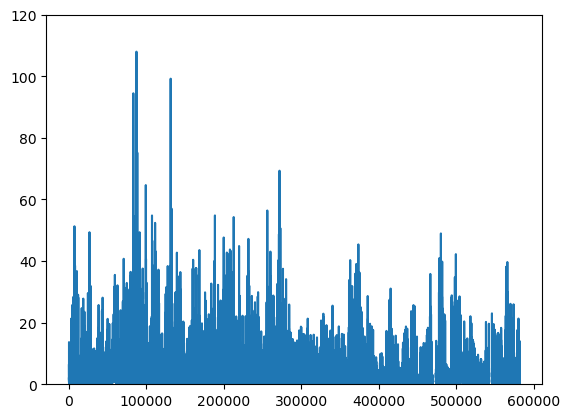

In [10]:
plt.plot(ratio['normalized_flow'])
plt.ylim(0,120)

In [ ]:
# This takes into account the possibility that the previous site’s last 1-2 days of data 
# may be accounted for if there’s a large event in the beginning of 2013 (this is not the case but is better for future data)
# Initialize new columns with NaN values
ratio["ratio_max_allyear"] = np.nan
ratio["ratio_sum_3day_allyear"] = np.nan

# Threshold for high normalized flow
normalized_flow_threshold = 17  # 17 mm/d is 7 cfs/sqkm

# Process each site separately to avoid cross-site contamination
for site, site_data in ratio.groupby("site_id"):
    # Get the indices where normalized flow is greater than 17 mm/d
    listrows = np.where(site_data['normalized_flow'] > normalized_flow_threshold)[0]  

    # Iterate over identified high flow rows
    for i in listrows:
        if i >= 2:  # Ensure we have at least 2 previous days **within the same site**
            # Get the max precipitation from [i-2, i-1, i] within the same site
            max_precip = site_data["prcp (mm/day)"].iloc[i-2:i+1].max()
            
            # Get the sum of precipitation from [i-2, i-1, i] within the same site
            sum_precip = site_data["prcp (mm/day)"].iloc[i-2:i+1].sum()
            
            # Compute ratios using .loc[] to avoid chained assignment
            ratio.loc[site_data.index[i], "ratio_max_allyear"] = site_data["normalized_flow"].iloc[i] / max_precip if max_precip > 0 else np.nan
            ratio.loc[site_data.index[i], "ratio_sum_3day_allyear"] = site_data["normalized_flow"].iloc[i] / sum_precip if sum_precip > 0 else np.nan
ratio


,year,yday,prcp (mm/day),lat,lon,site_id,datetime,flow,normalized_flow,flow_precip_ratio,ratio_max_allyear,ratio_sum_3day_allyear,ratio_max_summerfall,ratio_sum_3day_summerfall
0,2013.0,1.0,0.00,41.658983,-73.528458,01200000,2013-01-01,408.0,1.874264,inf,NaN,NaN,NaN,NaN
1,2013.0,2.0,0.00,41.658983,-73.528458,01200000,2013-01-02,376.0,1.727263,inf,NaN,NaN,NaN,NaN
2,2013.0,3.0,0.00,41.658983,-73.528458,01200000,2013-01-03,345.0,1.584855,inf,NaN,NaN,NaN,NaN
3,2013.0,4.0,0.00,41.658983,-73.528458,01200000,2013-01-04,338.0,1.552699,inf,NaN,NaN,NaN,NaN
4,2013.0,5.0,0.00,41.658983,-73.528458,01200000,2013-01-05,331.0,1.520543,inf,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582170,2023.0,361.0,6.19,43.463959,-73.284276,04280450,2023-12-27,543.0,3.049586,0.492663,NaN,NaN,NaN,NaN
582171,2023.0,362.0,2.43,43.463959,-73.284276,04280450,2023-12-28,550.0,3.088899,1.271152,NaN,NaN,NaN,NaN
582172,2023.0,363.0,5.67,43.463959,-73.284276,04280450,2023-12-29,508.0,2.853020,0.503178,NaN,NaN,NaN,NaN
582173,2023.0,364.0,1.37,43.463959,-73.284276,04280450,2023-12-30,640.0,3.594355,2.623617,NaN,NaN,NaN,NaN


In [20]:
# Count non-NaN values in the new columns- max vs 3day sum of precip
non_nan_ratio_max = ratio["ratio_max_allyear"].notna().sum()
non_nan_ratio_sum = ratio["ratio_sum_3day_allyear"].notna().sum()
print("Non-NaN values in ratio_max_allyear:", non_nan_ratio_max)
print("Non-NaN values in ratio_sum_3day_allyear:", non_nan_ratio_sum)

Non-NaN values in ratio_max_allyear: 994
Non-NaN values in ratio_sum_3day_allyear: 994


In [21]:
# Create a new DataFrame with rows where at least one of the new columns is not NaN
filtered_ratio = ratio.dropna(subset=["ratio_max_allyear", "ratio_sum_3day_allyear"], how='all')
filtered_ratio
#print("Number of rows in the filtered dataframe:", len(filtered_ratio))


,year,yday,prcp (mm/day),lat,lon,site_id,datetime,flow,normalized_flow,flow_precip_ratio,ratio_max_allyear,ratio_sum_3day_allyear,ratio_max_summerfall,ratio_sum_3day_summerfall
3164,2021.0,245.0,0.00,41.658983,-73.528458,01200000,2021-09-02,4650.0,21.361096,inf,0.163737,0.163737,0.163737,0.163737
4002,2023.0,353.0,0.00,41.658983,-73.528458,01200000,2023-12-19,4130.0,18.972328,inf,0.340067,0.222758,NaN,NaN
4173,2013.0,159.0,0.00,40.862306,-73.874389,01302020,2013-06-08,920.0,22.156993,inf,0.251156,0.222639,0.251156,0.222639
4345,2013.0,331.0,25.15,40.862306,-73.874389,01302020,2013-11-27,722.0,17.388423,0.691389,0.435582,0.267226,0.435582,0.267226
4468,2014.0,89.0,6.74,40.862306,-73.874389,01302020,2014-03-30,716.0,17.243921,2.558445,0.308644,0.273539,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572624,2019.0,305.0,0.00,44.358383,-73.396797,04276500,2019-11-01,6090.0,21.459114,inf,0.346954,0.324303,0.346954,0.324303
574060,2023.0,281.0,7.60,44.358383,-73.396797,04276500,2023-10-08,5940.0,20.930564,2.754022,0.238552,0.213012,0.238552,0.213012
574132,2023.0,353.0,0.00,44.358383,-73.396797,04276500,2023-12-19,7370.0,25.969404,inf,0.751429,0.438376,NaN,NaN
578883,2014.0,359.0,0.00,43.463959,-73.284276,04280450,2014-12-25,3130.0,17.578644,inf,0.848390,0.623356,NaN,NaN


In [22]:
# The number of unique site IDs
unique_site_ids = filtered_ratio["site_id"].nunique()
print("Number of unique site IDs:", unique_site_ids)

Number of unique site IDs: 96


In [23]:
# Now add columns that only take into account the summer/ fall months to remove snowmelt consequences
# Define summer/fall months
summer_fall_months = ["05", "06", "07", "08", "09", "10", "11"]  # Use string for the months

# Initialize new columns with NaN values
ratio["ratio_max_summerfall"] = np.nan
ratio["ratio_sum_3day_summerfall"] = np.nan

# Threshold for high normalized flow
normalized_flow_threshold = 17  # mm/d

# Process each site separately to avoid cross-site contamination
for site, site_data in ratio.groupby("site_id"):
    # Get the indices where normalized flow is greater than 7 mm/d
    listrows = np.where(site_data['normalized_flow'] > normalized_flow_threshold)[0]  

    # Iterate over identified high flow rows
    for i in listrows:
        # Extract the month as a string (assuming format is YYYY-MM-DD or similar)
        month_str = site_data["datetime"].iloc[i][5:7]  # Extract characters at position 5-6

        # Check if month is in summer/fall list
        if i >= 2 and month_str in summer_fall_months:
            # Get the max precipitation from [i-2, i-1, i] within the same site
            max_precip = site_data["prcp (mm/day)"].iloc[i-2:i+1].max()
            
            # Get the sum of precipitation from [i-2, i-1, i] within the same site
            sum_precip = site_data["prcp (mm/day)"].iloc[i-2:i+1].sum()
            
            # Compute ratios using .loc[] to avoid chained assignment
            ratio.loc[site_data.index[i], "ratio_max_summerfall"] = site_data["normalized_flow"].iloc[i] / max_precip if max_precip > 0 else np.nan
            ratio.loc[site_data.index[i], "ratio_sum_3day_summerfall"] = site_data["normalized_flow"].iloc[i] / sum_precip if sum_precip > 0 else np.nan
ratio


,year,yday,prcp (mm/day),lat,lon,site_id,datetime,flow,normalized_flow,flow_precip_ratio,ratio_max_allyear,ratio_sum_3day_allyear,ratio_max_summerfall,ratio_sum_3day_summerfall
0,2013.0,1.0,0.00,41.658983,-73.528458,01200000,2013-01-01,408.0,1.874264,inf,NaN,NaN,NaN,NaN
1,2013.0,2.0,0.00,41.658983,-73.528458,01200000,2013-01-02,376.0,1.727263,inf,NaN,NaN,NaN,NaN
2,2013.0,3.0,0.00,41.658983,-73.528458,01200000,2013-01-03,345.0,1.584855,inf,NaN,NaN,NaN,NaN
3,2013.0,4.0,0.00,41.658983,-73.528458,01200000,2013-01-04,338.0,1.552699,inf,NaN,NaN,NaN,NaN
4,2013.0,5.0,0.00,41.658983,-73.528458,01200000,2013-01-05,331.0,1.520543,inf,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582170,2023.0,361.0,6.19,43.463959,-73.284276,04280450,2023-12-27,543.0,3.049586,0.492663,NaN,NaN,NaN,NaN
582171,2023.0,362.0,2.43,43.463959,-73.284276,04280450,2023-12-28,550.0,3.088899,1.271152,NaN,NaN,NaN,NaN
582172,2023.0,363.0,5.67,43.463959,-73.284276,04280450,2023-12-29,508.0,2.853020,0.503178,NaN,NaN,NaN,NaN
582173,2023.0,364.0,1.37,43.463959,-73.284276,04280450,2023-12-30,640.0,3.594355,2.623617,NaN,NaN,NaN,NaN


In [24]:
# Count non-NaN values in the new columns
non_nan_ratio_max_summerfall = ratio["ratio_max_summerfall"].notna().sum()
non_nan_ratio_sum_summerfall = ratio["ratio_sum_3day_summerfall"].notna().sum()
print("Non-NaN values in ratio_max_summerfall:", non_nan_ratio_max_summerfall)
print("Non-NaN values in ratio_sum_3day_summerfall:", non_nan_ratio_sum_summerfall)

Non-NaN values in ratio_max_summerfall: 422
Non-NaN values in ratio_sum_3day_summerfall: 422


In [25]:
# The number of unique site IDs
unique_site_ids1 = ratio["site_id"].nunique()
print("Number of unique site IDs:", unique_site_ids)

Number of unique site IDs: 96


Large flow values for both max and the sum of 3 days total went from 971 to 359 (without May) and 414 with May. This means that the snowmelt accounts for a large portion of the large flow events.

In [32]:
# Create a new DataFrame with rows where at least one of the new columns is not NaN
# may need 2 dataframes- one of summer/fall and one all year because they have different amounts of site_ids 
filtered_ratio = ratio.dropna(subset=["ratio_max_summerfall", "ratio_sum_3day_summerfall"], how='all')
#filtered_ratio = ratio.dropna(subset=["ratio_max_allyear"], how='all')
filtered_ratio

,year,yday,prcp (mm/day),lat,lon,site_id,datetime,flow,normalized_flow,flow_precip_ratio,ratio_max_allyear,ratio_sum_3day_allyear,ratio_max_summerfall,ratio_sum_3day_summerfall
3164,2021.0,245.0,0.000000,41.658983,-73.528458,01200000,2021-09-02,4650.0,21.361096,inf,0.163737,0.163737,0.163737,0.163737
4173,2013.0,159.0,0.000000,40.862306,-73.874389,01302020,2013-06-08,920.0,22.156993,inf,0.251156,0.222639,0.251156,0.222639
4345,2013.0,331.0,25.150000,40.862306,-73.874389,01302020,2013-11-27,722.0,17.388423,0.691389,0.435582,0.267226,0.435582,0.267226
4500,2014.0,121.0,1.100000,40.862306,-73.874389,01302020,2014-05-01,1070.0,25.769546,23.426860,0.226944,0.208627,0.226944,0.208627
6107,2018.0,268.0,73.660004,40.862306,-73.874389,01302020,2018-09-25,753.0,18.135017,0.246199,0.246199,0.232322,0.246199,0.232322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566616,2014.0,137.0,30.299999,44.451436,-73.642638,04275500,2014-05-17,8400.0,17.842155,0.588850,0.588850,0.311653,0.588850,0.311653
568609,2019.0,305.0,0.000000,44.451436,-73.642638,04275500,2019-11-01,11900.0,25.276386,inf,0.628766,0.578407,0.628766,0.578407
570045,2023.0,281.0,0.000000,44.451436,-73.642638,04275500,2023-10-08,9280.0,19.711333,inf,0.199973,0.181906,0.199973,0.181906
572624,2019.0,305.0,0.000000,44.358383,-73.396797,04276500,2019-11-01,6090.0,21.459114,inf,0.346954,0.324303,0.346954,0.324303


In [33]:
# The number of unique site IDs
unique_site_ids = filtered_ratio["site_id"].nunique()
print("Number of unique site IDs:", unique_site_ids)

Number of unique site IDs: 84


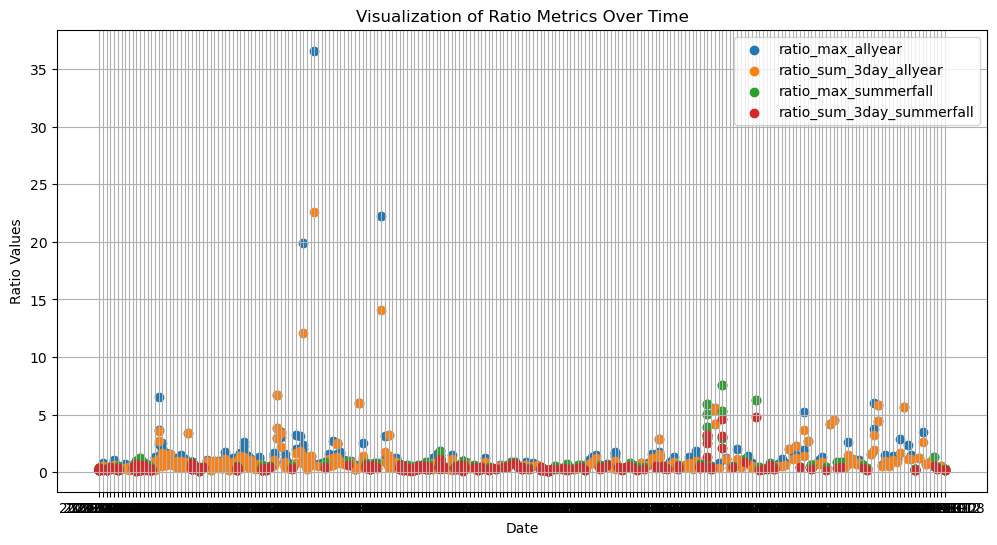

In [28]:
plt.figure(figsize=(12, 6))

for col in ["ratio_max_allyear", "ratio_sum_3day_allyear", "ratio_max_summerfall", "ratio_sum_3day_summerfall"]:
    plt.scatter(filtered_ratio['datetime'], filtered_ratio[col], label=col)

plt.xlabel("Date")
plt.ylabel("Ratio Values")
plt.title("Visualization of Ratio Metrics Over Time")
plt.legend()
plt.grid(True)

plt.show()

Now, average runoff ratios by sites and make this into a new dataframe csv file

In [29]:
# Group by site_id and compute the mean for all columns from "normalized_flow" onward
average_runoff_ratios = filtered_ratio.groupby("site_id").mean(numeric_only=True)

# Reset index so site_id remains a column
average_runoff_ratios = average_runoff_ratios.reset_index()
# Ensure site_id remains a string after resetting index
average_runoff_ratios["site_id"] = average_runoff_ratios["site_id"].astype(str)
# remove unwanted columns (the lines of code above also took their average- these columns were time)
# remove the 3 from this line below if you want to include the ave prcp
# 8 removes flow_precip_ratio
average_runoff_ratios.drop(average_runoff_ratios.columns[[1, 2, 3, 8]], axis=1, inplace=True) 
# rename prcp so it's clear it's also an average
# average_runoff_ratios.rename(columns={"prcp (mm/day)": "ave prcp (mm/day)"}, inplace=True)
average_runoff_ratios

,site_id,lat,lon,flow,normalized_flow,ratio_max_allyear,ratio_sum_3day_allyear,ratio_max_summerfall,ratio_sum_3day_summerfall
0,01200000,41.658983,-73.528458,4390.000000,20.166712,0.251902,0.193248,0.163737,0.163737
1,01302020,40.862306,-73.874389,980.800000,23.621281,0.370472,0.249070,0.321761,0.223398
2,01312000,43.966174,-74.130704,4997.333333,24.540149,1.061907,0.854277,0.357251,0.327461
3,01315500,43.700898,-73.983466,18466.666667,21.947499,0.531907,0.423391,0.334060,0.323568
4,01318500,43.318960,-73.844289,31900.000000,18.013500,0.541590,0.443783,NaN,NaN
...,...,...,...,...,...,...,...,...,...
91,04271815,44.902262,-73.415135,960.500000,18.002114,0.545098,0.317950,0.421214,0.269958
92,04275000,44.438936,-73.681528,4897.692308,23.366742,0.849791,0.629475,0.626369,0.517644
93,04275500,44.451436,-73.642638,10175.000000,21.612372,1.474735,0.882041,0.525266,0.329132
94,04276500,44.358383,-73.396797,6466.666667,22.786361,0.445645,0.325230,0.292753,0.268657


In [46]:
print(average_runoff_ratios[average_runoff_ratios["ratio_max_summerfall"].isna()])

     site_id        lat        lon          flow  normalized_flow  \
4   01318500  43.318960 -73.844289  31900.000000        18.013500   
6   01329490  43.108687 -73.421779   9260.000000        22.068206   
8   01334500  42.938689 -73.377056  10367.500000        19.152831   
25  01364500  42.037869 -73.972081   8130.000000        18.342226   
46  01417000  42.075087 -74.976275   8740.000000        22.252429   
47  01417500  42.024809 -75.119890   9490.000000        19.610282   
50  01421610  42.371470 -74.669042    388.000000        24.435822   
52  01425000  42.074806 -75.396009   8290.000000        17.180035   
73  04223000  42.570341 -78.042228  18966.666667        18.214088   
86  04260500  43.985616 -75.924646  39550.000000        19.980379   
88  04269000  44.863664 -74.778801  13050.000000        20.016381   
95  04280450  43.463959 -73.284276   3465.000000        19.460065   

    ratio_max_allyear  ratio_sum_3day_allyear  ratio_max_summerfall  \
4            0.541590          

In [31]:
# Export df to a .csv
average_runoff_ratios.to_csv("average_event_ratios03.22.25.csv", index= False)

The average_event_ratio csv is derived from a dataframe of site_ids in NYS that have daily data from 2013-2024 and have events where normalized flow is above 7 mm/day. These events were then averaged for each site. There are 96 from the original 145 sites that have flow above 7 mm/day at least once. 

In [30]:
num_obs_per_site = filtered_ratio.groupby("site_id").count()
num_obs_per_site

,year,yday,prcp (mm/day),lat,lon,datetime,flow,normalized_flow,flow_precip_ratio,ratio_max_allyear,ratio_sum_3day_allyear,ratio_max_summerfall,ratio_sum_3day_summerfall
site_id,,,,,,,,,,,,,
01200000,2,2,2,2,2,2,2,2,2,2,2,1,1
01302020,15,15,15,15,15,15,15,15,15,15,15,10,10
01312000,15,15,15,15,15,15,15,15,15,15,15,4,4
01315500,9,9,9,9,9,9,9,9,9,9,9,3,3
01318500,2,2,2,2,2,2,2,2,2,2,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
04271815,2,2,2,2,2,2,2,2,2,2,2,1,1
04275000,13,13,13,13,13,13,13,13,13,13,13,4,4
04275500,10,10,10,10,10,10,10,10,10,10,10,4,4


In [42]:
weights_data = num_obs_per_site[["ratio_max_allyear","ratio_max_summerfall"]]
weights_data
# Export df to a .csv
#weights_data.to_csv("weights_data.csv", index= False)

,ratio_max_allyear,ratio_max_summerfall
site_id,,
01200000,2,1
01302020,15,10
01312000,15,4
01315500,9,3
01318500,2,0
...,...,...
04271815,2,1
04275000,13,4
04275500,10,4
